##Nuclei detection with Mask RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

D:\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [3]:
## Define RLE encoding functions
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


def mask_encode(masks):
    n_mask = masks.shape[2]
    res = []
    for i in range(n_mask):
        encode_one = prob_to_rles(masks[:, :, i])
        res.extend(encode_one)
    return res

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon


def plot_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N_box = boxes.shape[0]
    N_mask = masks.shape[2]
    if not N_box:
        print("\n*** No instances to display *** \n")
    #else:
    #    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors_box = visualize.random_colors(N_box)
    colors_mask = visualize.random_colors(N_mask)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N_box):
        color = colors_box[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")
    for i in range(N_mask):
        # Mask
        mask = masks[:, :, i]
        color = colors_mask[i]
        masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig("./plot/" + title + ".png", bbox_inches='tight')
    plt.close()

##Configuration

In [6]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 16, 32, 64, 256)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERE

## Dataset

Create a nuclei dataset



In [7]:
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


StopIteration: 

In [8]:
# Augmented image training

batch_name = "AugBatch1"

TRAIN_PATH = './input/' + batch_name + "/"
TEST_PATH = './input/stage1_test/'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [9]:
# Function to remove overlapping portion of masks (keep the portion with higher score)
def remove_overlap(masks):
    n_masks = masks.shape[2]

    for i in range(n_masks):
        good_mask = masks[:, :, i]
        for j in range(i + 1, n_masks):
            fix_mask = masks[:, :, j]
            overlapping = (good_mask == 1) & (fix_mask == 1)
            if np.any(overlapping):
                print('Overlapping mask detected!')
                fix_mask[overlapping] = 0
                masks[:, :, j] = fix_mask
    return masks

In [10]:
# create the nuclei dataset
class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        # Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids

In [11]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
# print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


number of white_black image: 599
number of purple_yellow image: 8
number of purple_white image: 41
number of purple_purple image: 71
number of black_white image: 16


In [9]:
print(cate['filename'][1][:-4])

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0


In [12]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531
length of validation set: 133
False


In [13]:

# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

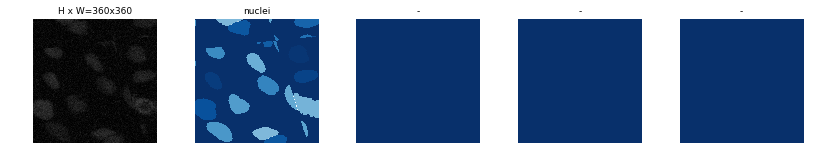

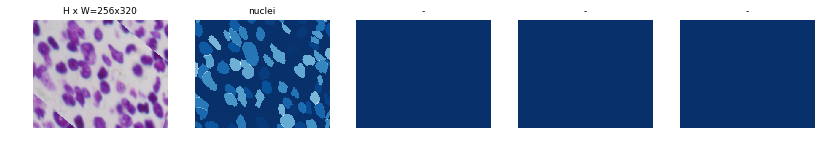

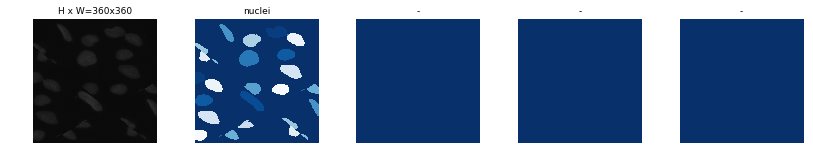

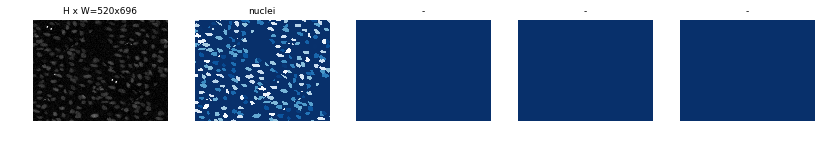

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)


##Create model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with? Used coco weights? 
init_with = "name"  # imagenet, coco, or last
model_name = 'mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5'
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "name":
    print("loading:",model_name)
    # Load the last model you trained and continue training
    model.load_weights(os.path.join(MODEL_DIR, model_name), by_name=True)


loading: mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5


##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [17]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')

Instructions for updating:
Use the retry module or similar alternatives.



Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Kaggle\Kaggle2018\logs\nuclei20180401T0347\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

D:\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


  1/100 [..............................] - ETA: 19:44 - loss: 2.4695 - rpn_class_loss: 0.1569 - rpn_bbox_loss: 1.3694 - mrcnn_class_loss: 0.3793 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.3032

  2/100 [..............................] - ETA: 11:43 - loss: 1.9064 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 1.0629 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.1890 - mrcnn_mask_loss: 0.2386

  3/100 [..............................] - ETA: 8:59 - loss: 1.9892 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 1.1748 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.1861 - mrcnn_mask_loss: 0.2452 

  4/100 [>.............................] - ETA: 7:26 - loss: 2.0467 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 1.0152 - mrcnn_class_loss: 0.3720 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.3034

  5/100 [>.............................] - ETA: 6:41 - loss: 2.1105 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 1.0540 - mrcnn_class_loss: 0.3625 - mrcnn_bbox_loss: 0.2613 - mrcnn_mask_loss: 0.3060

  6/100 [>.............................] - ETA: 6:10 - loss: 1.9928 - rpn_class_loss: 0.1144 - rpn_bbox_loss: 0.9934 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.3124

  7/100 [=>............................] - ETA: 5:36 - loss: 2.0814 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.3051

  8/100 [=>............................] - ETA: 5:18 - loss: 2.0644 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 1.1663 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2840

  9/100 [=>............................] - ETA: 5:00 - loss: 2.0788 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.2270 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.2794

 10/100 [==>...........................] - ETA: 4:41 - loss: 2.0901 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 1.2645 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.2798

 11/100 [==>...........................] - ETA: 4:51 - loss: 2.1304 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 1.2881 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.2790

 12/100 [==>...........................] - ETA: 4:44 - loss: 2.1895 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.3111 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2898

 13/100 [==>...........................] - ETA: 5:49 - loss: 2.2691 - rpn_class_loss: 0.1221 - rpn_bbox_loss: 1.3412 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.3028

 14/100 [===>..........................] - ETA: 5:59 - loss: 2.2785 - rpn_class_loss: 0.1195 - rpn_bbox_loss: 1.3371 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.3073

 15/100 [===>..........................] - ETA: 5:49 - loss: 2.2661 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 1.3366 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.2505 - mrcnn_mask_loss: 0.3035

 16/100 [===>..........................] - ETA: 5:42 - loss: 2.2758 - rpn_class_loss: 0.1147 - rpn_bbox_loss: 1.3323 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.2566 - mrcnn_mask_loss: 0.3079

 17/100 [====>.........................] - ETA: 5:32 - loss: 2.2701 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 1.3440 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.3026

 18/100 [====>.........................] - ETA: 5:25 - loss: 2.2602 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 1.3417 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.3002

 19/100 [====>.........................] - ETA: 5:15 - loss: 2.2757 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 1.3594 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.3035

 20/100 [=====>........................] - ETA: 5:04 - loss: 2.3094 - rpn_class_loss: 0.1093 - rpn_bbox_loss: 1.3878 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.3087

 21/100 [=====>........................] - ETA: 5:09 - loss: 2.3076 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 1.3895 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.3068

 22/100 [=====>........................] - ETA: 5:02 - loss: 2.3684 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 1.4883 - mrcnn_class_loss: 0.2353 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.2928

 23/100 [=====>........................] - ETA: 4:52 - loss: 2.3462 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 1.4876 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.2857

 24/100 [======>.......................] - ETA: 4:41 - loss: 2.2803 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 1.4416 - mrcnn_class_loss: 0.2242 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.2803

 25/100 [======>.......................] - ETA: 4:36 - loss: 2.3129 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 1.4779 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.2788

 26/100 [======>.......................] - ETA: 4:47 - loss: 2.2982 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 1.4635 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.2771

 27/100 [=======>......................] - ETA: 4:38 - loss: 2.2959 - rpn_class_loss: 0.1067 - rpn_bbox_loss: 1.4518 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.2832

 28/100 [=======>......................] - ETA: 4:46 - loss: 2.2965 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2826

 29/100 [=======>......................] - ETA: 4:40 - loss: 2.3160 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 1.4610 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2864

 30/100 [========>.....................] - ETA: 4:37 - loss: 2.2683 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.4364 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.2768

 31/100 [========>.....................] - ETA: 4:27 - loss: 2.3081 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 1.4767 - mrcnn_class_loss: 0.2095 - mrcnn_bbox_loss: 0.2307 - mrcnn_mask_loss: 0.2816

 32/100 [========>.....................] - ETA: 4:30 - loss: 2.2863 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 1.4586 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.2777

 33/100 [========>.....................] - ETA: 4:22 - loss: 2.2782 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 1.4615 - mrcnn_class_loss: 0.2095 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.2771

 34/100 [=========>....................] - ETA: 4:15 - loss: 2.3224 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 1.5073 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.2782

 35/100 [=========>....................] - ETA: 4:08 - loss: 2.3032 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 1.4955 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2755

 36/100 [=========>....................] - ETA: 4:02 - loss: 2.2901 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 1.4925 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.2714

D:\Anaconda3\envs\kaggle\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 37/100 [==========>...................] - ETA: 3:58 - loss: 2.2843 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 1.4819 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2720

 38/100 [==========>...................] - ETA: 3:54 - loss: 2.2790 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.4758 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2709

 39/100 [==========>...................] - ETA: 3:48 - loss: 2.2936 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 1.4818 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2695

 40/100 [===========>..................] - ETA: 3:46 - loss: 2.2905 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 1.4791 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.2690

 41/100 [===========>..................] - ETA: 3:39 - loss: 2.2665 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 1.4562 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2691

 42/100 [===========>..................] - ETA: 3:34 - loss: 2.2663 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 1.4645 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2663

 43/100 [===========>..................] - ETA: 3:28 - loss: 2.2837 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 1.4853 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.2635

 44/100 [============>.................] - ETA: 3:22 - loss: 2.2923 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.4924 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.2670

 45/100 [============>.................] - ETA: 3:17 - loss: 2.2859 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 1.4975 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2635

 46/100 [============>.................] - ETA: 3:12 - loss: 2.3030 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.5004 - mrcnn_class_loss: 0.2074 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.2764

 47/100 [=============>................] - ETA: 3:06 - loss: 2.2944 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 1.4900 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.2741

 48/100 [=============>................] - ETA: 3:03 - loss: 2.2921 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 1.4885 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.2738

 49/100 [=============>................] - ETA: 2:58 - loss: 2.3070 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.4886 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.2797

 50/100 [==============>...............] - ETA: 2:53 - loss: 2.3182 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.4944 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.2822

 51/100 [==============>...............] - ETA: 2:48 - loss: 2.3014 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 1.4853 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.2785

 52/100 [==============>...............] - ETA: 2:44 - loss: 2.3027 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.4904 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.2355 - mrcnn_mask_loss: 0.2771

 53/100 [==============>...............] - ETA: 2:39 - loss: 2.2872 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 1.4826 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.2751

 54/100 [===============>..............] - ETA: 2:35 - loss: 2.2811 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.4781 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.2740

 55/100 [===============>..............] - ETA: 2:31 - loss: 2.2585 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 1.4625 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2720

 56/100 [===============>..............] - ETA: 2:27 - loss: 2.2623 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4607 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2731

 57/100 [================>.............] - ETA: 2:23 - loss: 2.2720 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.4625 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2759

 58/100 [================>.............] - ETA: 2:19 - loss: 2.2722 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4614 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.2740

 59/100 [================>.............] - ETA: 2:15 - loss: 2.2654 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4553 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.2727

 60/100 [=================>............] - ETA: 2:11 - loss: 2.2657 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.4533 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2739

 61/100 [=================>............] - ETA: 2:07 - loss: 2.2545 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2727

 62/100 [=================>............] - ETA: 2:04 - loss: 2.2610 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4435 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2747

 63/100 [=================>............] - ETA: 2:02 - loss: 2.2528 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4297 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2755

 64/100 [==================>...........] - ETA: 1:58 - loss: 2.2425 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4179 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.2776

 65/100 [==================>...........] - ETA: 1:54 - loss: 2.2573 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.4359 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2762

 66/100 [==================>...........] - ETA: 1:50 - loss: 2.2332 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.4189 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2743

 67/100 [===================>..........] - ETA: 1:49 - loss: 2.2229 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.4110 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.2734

 68/100 [===================>..........] - ETA: 1:45 - loss: 2.2169 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4054 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2721

 69/100 [===================>..........] - ETA: 1:43 - loss: 2.2245 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4039 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.2702

 70/100 [====================>.........] - ETA: 1:41 - loss: 2.2251 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4032 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.2499 - mrcnn_mask_loss: 0.2709

 71/100 [====================>.........] - ETA: 1:38 - loss: 2.2092 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.3926 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.2688

 72/100 [====================>.........] - ETA: 1:34 - loss: 2.2010 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.3878 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2678

 73/100 [====================>.........] - ETA: 1:31 - loss: 2.1911 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.3805 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.2676

 74/100 [=====================>........] - ETA: 1:27 - loss: 2.1908 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.3825 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.2665

 75/100 [=====================>........] - ETA: 1:23 - loss: 2.1818 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.3757 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2661

 76/100 [=====================>........] - ETA: 1:19 - loss: 2.1766 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.3739 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.2645

 77/100 [======================>.......] - ETA: 1:20 - loss: 2.1713 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.3677 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2646

 78/100 [======================>.......] - ETA: 1:18 - loss: 2.1819 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.3633 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2677

 79/100 [======================>.......] - ETA: 1:14 - loss: 2.1775 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.3611 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.2669

 80/100 [=======================>......] - ETA: 1:11 - loss: 2.1727 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.3569 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2668

 81/100 [=======================>......] - ETA: 1:07 - loss: 2.1779 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.2648

 82/100 [=======================>......] - ETA: 1:03 - loss: 2.1724 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.3589 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2653

 83/100 [=======================>......] - ETA: 1:01 - loss: 2.1644 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.3508 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2647

 84/100 [========================>.....] - ETA: 57s - loss: 2.1707 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.3508 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.2479 - mrcnn_mask_loss: 0.2668 

 85/100 [========================>.....] - ETA: 53s - loss: 2.1597 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.3430 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.2674

 86/100 [========================>.....] - ETA: 50s - loss: 2.1548 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.3419 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.2667

 87/100 [=========================>....] - ETA: 46s - loss: 2.1491 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.3372 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.2662

 88/100 [=========================>....] - ETA: 42s - loss: 2.1348 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.3261 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2660

 89/100 [=========================>....] - ETA: 39s - loss: 2.1350 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.3283 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.2655

 90/100 [==========================>...] - ETA: 35s - loss: 2.1358 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.3276 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.2656

 91/100 [==========================>...] - ETA: 31s - loss: 2.1362 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.3226 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2673

 92/100 [==========================>...] - ETA: 28s - loss: 2.1302 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.3182 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.2659

 93/100 [==========================>...] - ETA: 25s - loss: 2.1367 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.3166 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.2668

 94/100 [===========================>..] - ETA: 21s - loss: 2.1350 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.3141 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.2666

 95/100 [===========================>..] - ETA: 18s - loss: 2.1323 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.3107 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.2673

 96/100 [===========================>..] - ETA: 14s - loss: 2.1304 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.2684

 97/100 [============================>.] - ETA: 10s - loss: 2.1332 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 1.3060 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2701

 98/100 [============================>.] - ETA: 7s - loss: 2.1461 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.3091 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.2728 

 99/100 [============================>.] - ETA: 3s - loss: 2.1481 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.3105 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.2718

100/100 [==============================] - 375s 4s/step - loss: 2.1440 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.3091 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.2705 - val_loss: 2.5187 - val_rpn_class_loss: 0.1188 - val_rpn_bbox_loss: 1.1883 - val_mrcnn_class_loss: 0.4756 - val_mrcnn_bbox_loss: 0.3571 - val_mrcnn_mask_loss: 0.3790


Epoch 2/10


  1/100 [..............................] - ETA: 5:08 - loss: 2.0634 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.3406 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.1751

  2/100 [..............................] - ETA: 4:29 - loss: 2.5343 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.6216 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.2073

  3/100 [..............................] - ETA: 4:45 - loss: 2.3744 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3951 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.2601

  4/100 [>.............................] - ETA: 5:22 - loss: 2.3924 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.4003 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.2703

  5/100 [>.............................] - ETA: 5:03 - loss: 2.3126 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3716 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.2685

  6/100 [>.............................] - ETA: 4:57 - loss: 2.1838 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3255 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.2822 - mrcnn_mask_loss: 0.2452

  7/100 [=>............................] - ETA: 4:41 - loss: 2.1520 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3081 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.2645

  8/100 [=>............................] - ETA: 4:22 - loss: 2.0582 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.2778 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.2478

  9/100 [=>............................] - ETA: 4:37 - loss: 2.0072 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2146 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2541

 10/100 [==>...........................] - ETA: 4:40 - loss: 2.0669 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.2352 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.2712

 11/100 [==>...........................] - ETA: 4:24 - loss: 2.0697 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.2690 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2565 - mrcnn_mask_loss: 0.2546

 12/100 [==>...........................] - ETA: 4:19 - loss: 2.0507 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.2736 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2441

 13/100 [==>...........................] - ETA: 4:10 - loss: 2.0122 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2502 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.2371

 14/100 [===>..........................] - ETA: 4:09 - loss: 2.0432 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.2331 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.2520 - mrcnn_mask_loss: 0.2546

 15/100 [===>..........................] - ETA: 4:06 - loss: 1.9908 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.1989 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.2472

 16/100 [===>..........................] - ETA: 4:00 - loss: 1.9946 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.2166 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2416

 17/100 [====>.........................] - ETA: 3:52 - loss: 2.0015 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2413 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2373

 18/100 [====>.........................] - ETA: 3:43 - loss: 2.0270 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.2826 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.2292

 19/100 [====>.........................] - ETA: 3:36 - loss: 2.0427 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.2802 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.2374

 20/100 [=====>........................] - ETA: 3:29 - loss: 2.0639 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.2896 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.2344

 21/100 [=====>........................] - ETA: 3:23 - loss: 2.0735 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.2935 - mrcnn_class_loss: 0.2108 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.2307

 22/100 [=====>........................] - ETA: 3:19 - loss: 2.1298 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.3478 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.2254

 23/100 [=====>........................] - ETA: 3:14 - loss: 2.1103 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.3318 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2237

 24/100 [======>.......................] - ETA: 3:09 - loss: 2.0695 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.2985 - mrcnn_class_loss: 0.2056 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 0.2254

 25/100 [======>.......................] - ETA: 3:09 - loss: 2.0678 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.2913 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.2909 - mrcnn_mask_loss: 0.2264

 26/100 [======>.......................] - ETA: 3:07 - loss: 2.0466 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.2739 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.2259

 27/100 [=======>......................] - ETA: 3:08 - loss: 2.0528 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.2694 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 0.2221

 28/100 [=======>......................] - ETA: 3:03 - loss: 2.0550 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.2737 - mrcnn_class_loss: 0.2133 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2185

 29/100 [=======>......................] - ETA: 3:01 - loss: 2.0872 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2975 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.2222

 30/100 [========>.....................] - ETA: 2:57 - loss: 2.1118 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.3244 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.2188

 31/100 [========>.....................] - ETA: 2:58 - loss: 2.1105 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.3132 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.2206

 32/100 [========>.....................] - ETA: 2:55 - loss: 2.1150 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.3113 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.2269

 33/100 [========>.....................] - ETA: 2:51 - loss: 2.0821 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2861 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.3004 - mrcnn_mask_loss: 0.2273

 34/100 [=========>....................] - ETA: 2:46 - loss: 2.1337 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.3345 - mrcnn_class_loss: 0.2084 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.2211

 35/100 [=========>....................] - ETA: 2:42 - loss: 2.1198 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.3173 - mrcnn_class_loss: 0.2083 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2213

 36/100 [=========>....................] - ETA: 2:39 - loss: 2.1284 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.3244 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.3213 - mrcnn_mask_loss: 0.2189

 37/100 [==========>...................] - ETA: 2:38 - loss: 2.1331 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3259 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.3190 - mrcnn_mask_loss: 0.2197

 38/100 [==========>...................] - ETA: 2:34 - loss: 2.1007 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.3019 - mrcnn_class_loss: 0.2106 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.2200

 39/100 [==========>...................] - ETA: 2:31 - loss: 2.1145 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.2954 - mrcnn_class_loss: 0.2080 - mrcnn_bbox_loss: 0.3222 - mrcnn_mask_loss: 0.2356

 40/100 [===========>..................] - ETA: 2:33 - loss: 2.1081 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.2888 - mrcnn_class_loss: 0.2117 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.2342

 41/100 [===========>..................] - ETA: 2:30 - loss: 2.0988 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.2830 - mrcnn_class_loss: 0.2102 - mrcnn_bbox_loss: 0.3170 - mrcnn_mask_loss: 0.2347

 42/100 [===========>..................] - ETA: 2:27 - loss: 2.1049 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.2857 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.2361

 43/100 [===========>..................] - ETA: 2:24 - loss: 2.1151 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.2935 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2330

 44/100 [============>.................] - ETA: 2:21 - loss: 2.1279 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.3056 - mrcnn_class_loss: 0.2066 - mrcnn_bbox_loss: 0.3294 - mrcnn_mask_loss: 0.2330

 45/100 [============>.................] - ETA: 2:17 - loss: 2.1157 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.2958 - mrcnn_class_loss: 0.2062 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.2340

 46/100 [============>.................] - ETA: 2:14 - loss: 2.1201 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.2992 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.2357

 47/100 [=============>................] - ETA: 2:12 - loss: 2.1120 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.2906 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.2377

 48/100 [=============>................] - ETA: 2:09 - loss: 2.1187 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.2904 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 0.2384

 49/100 [=============>................] - ETA: 2:07 - loss: 2.1222 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.2934 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.2405

 50/100 [==============>...............] - ETA: 2:04 - loss: 2.1181 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.2927 - mrcnn_class_loss: 0.2036 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.2398

 51/100 [==============>...............] - ETA: 2:03 - loss: 2.1120 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.2897 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.3231 - mrcnn_mask_loss: 0.2390

 52/100 [==============>...............] - ETA: 2:00 - loss: 2.1537 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.2867 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.3506 - mrcnn_mask_loss: 0.2602

 53/100 [==============>...............] - ETA: 1:56 - loss: 2.1352 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.2726 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.3478 - mrcnn_mask_loss: 0.2605

 54/100 [===============>..............] - ETA: 2:04 - loss: 2.1500 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2795 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.3482 - mrcnn_mask_loss: 0.2649

 55/100 [===============>..............] - ETA: 2:00 - loss: 2.1329 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2710 - mrcnn_class_loss: 0.1952 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2630

 56/100 [===============>..............] - ETA: 1:59 - loss: 2.1254 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 0.1968 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.2633

 57/100 [================>.............] - ETA: 1:58 - loss: 2.1232 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2621 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.3408 - mrcnn_mask_loss: 0.2622

 58/100 [================>.............] - ETA: 1:55 - loss: 2.1145 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2581 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.2595

 59/100 [================>.............] - ETA: 1:56 - loss: 2.1027 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2477 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.3345 - mrcnn_mask_loss: 0.2588

 60/100 [=================>............] - ETA: 1:56 - loss: 2.1154 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.2532 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.2578

 61/100 [=================>............] - ETA: 1:53 - loss: 2.1029 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.2478 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.2554

 62/100 [=================>............] - ETA: 1:50 - loss: 2.0951 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.2447 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.3354 - mrcnn_mask_loss: 0.2537

 63/100 [=================>............] - ETA: 1:47 - loss: 2.0890 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.2385 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.2543

 64/100 [==================>...........] - ETA: 1:46 - loss: 2.0980 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.2418 - mrcnn_class_loss: 0.2032 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.2522

 65/100 [==================>...........] - ETA: 1:43 - loss: 2.0872 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2349 - mrcnn_class_loss: 0.2036 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.2512

 66/100 [==================>...........] - ETA: 1:39 - loss: 2.0938 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.2388 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.3396 - mrcnn_mask_loss: 0.2517

 67/100 [===================>..........] - ETA: 1:36 - loss: 2.0928 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.2389 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.2514

 68/100 [===================>..........] - ETA: 1:33 - loss: 2.0901 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.2359 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.3384 - mrcnn_mask_loss: 0.2516

 69/100 [===================>..........] - ETA: 1:30 - loss: 2.0976 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.2458 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.3404 - mrcnn_mask_loss: 0.2489

 70/100 [====================>.........] - ETA: 1:27 - loss: 2.1049 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.2493

 71/100 [====================>.........] - ETA: 1:23 - loss: 2.1009 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2486 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.3428 - mrcnn_mask_loss: 0.2480

 72/100 [====================>.........] - ETA: 1:20 - loss: 2.1062 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2531 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss: 0.2473

 73/100 [====================>.........] - ETA: 1:17 - loss: 2.0872 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.2408 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.2461

 74/100 [=====================>........] - ETA: 1:16 - loss: 2.0923 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.2477 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.2456

 75/100 [=====================>........] - ETA: 1:13 - loss: 2.0944 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.2551 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.3365 - mrcnn_mask_loss: 0.2441

 76/100 [=====================>........] - ETA: 1:10 - loss: 2.0946 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.2564 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.3358 - mrcnn_mask_loss: 0.2432

 77/100 [======================>.......] - ETA: 1:07 - loss: 2.0798 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.2449 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.3332 - mrcnn_mask_loss: 0.2425

 78/100 [======================>.......] - ETA: 1:04 - loss: 2.0928 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.2542 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.3350 - mrcnn_mask_loss: 0.2458

 79/100 [======================>.......] - ETA: 1:01 - loss: 2.0967 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2591 - mrcnn_class_loss: 0.1960 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2445

 80/100 [=======================>......] - ETA: 58s - loss: 2.0974 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2621 - mrcnn_class_loss: 0.1944 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.2431 

 81/100 [=======================>......] - ETA: 55s - loss: 2.0951 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.2577 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2439

 82/100 [=======================>......] - ETA: 52s - loss: 2.1009 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2610 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.2445

 83/100 [=======================>......] - ETA: 49s - loss: 2.1039 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2596 - mrcnn_class_loss: 0.2000 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.2471

 84/100 [========================>.....] - ETA: 46s - loss: 2.1056 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.2578 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.3367 - mrcnn_mask_loss: 0.2493

 85/100 [========================>.....] - ETA: 43s - loss: 2.0978 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.2495 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.2494

 86/100 [========================>.....] - ETA: 41s - loss: 2.0934 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.2431 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.2500

 87/100 [=========================>....] - ETA: 38s - loss: 2.1054 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2544 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2491

 88/100 [=========================>....] - ETA: 35s - loss: 2.1042 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.2528 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.2500

 89/100 [=========================>....] - ETA: 32s - loss: 2.1105 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.2539 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.3361 - mrcnn_mask_loss: 0.2517

 90/100 [==========================>...] - ETA: 29s - loss: 2.1165 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.2579 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.2511

 91/100 [==========================>...] - ETA: 26s - loss: 2.1153 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.2568 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.2512

 92/100 [==========================>...] - ETA: 24s - loss: 2.1115 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.2538 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.2506

 93/100 [==========================>...] - ETA: 21s - loss: 2.1073 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2488 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.2510

 94/100 [===========================>..] - ETA: 18s - loss: 2.1085 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.2482 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.2516

 95/100 [===========================>..] - ETA: 15s - loss: 2.0987 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.2409 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2511

 96/100 [===========================>..] - ETA: 12s - loss: 2.0921 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.2348 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3319 - mrcnn_mask_loss: 0.2518

 97/100 [============================>.] - ETA: 9s - loss: 2.0779 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2256 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.2512 

 98/100 [============================>.] - ETA: 5s - loss: 2.0797 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2255 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.2518

 99/100 [============================>.] - ETA: 3s - loss: 2.0802 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2245 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.2516

100/100 [==============================] - 301s 3s/step - loss: 2.0949 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2328 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.2547 - val_loss: 2.4622 - val_rpn_class_loss: 0.1016 - val_rpn_bbox_loss: 1.1714 - val_mrcnn_class_loss: 0.3858 - val_mrcnn_bbox_loss: 0.5158 - val_mrcnn_mask_loss: 0.2877


Epoch 3/10


  1/100 [..............................] - ETA: 5:26 - loss: 1.9077 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.9255 - mrcnn_class_loss: 0.2907 - mrcnn_bbox_loss: 0.2625 - mrcnn_mask_loss: 0.3266

  2/100 [..............................] - ETA: 6:32 - loss: 1.8422 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.9298 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.2620

  3/100 [..............................] - ETA: 6:11 - loss: 2.0312 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 1.0793 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.2204

  4/100 [>.............................] - ETA: 5:23 - loss: 1.8051 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.9846 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.1920

  5/100 [>.............................] - ETA: 4:46 - loss: 1.5762 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 0.8681 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.2563 - mrcnn_mask_loss: 0.1791

  6/100 [>.............................] - ETA: 5:01 - loss: 1.5429 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.8333 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.1905

  7/100 [=>............................] - ETA: 4:42 - loss: 1.4949 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.8094 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 0.1852

  8/100 [=>............................] - ETA: 5:27 - loss: 1.6178 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 0.8599 - mrcnn_class_loss: 0.2280 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2024

  9/100 [=>............................] - ETA: 5:26 - loss: 1.5997 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.8593 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.2324 - mrcnn_mask_loss: 0.2015

 10/100 [==>...........................] - ETA: 5:11 - loss: 1.6693 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.9279 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2027

 11/100 [==>...........................] - ETA: 5:02 - loss: 1.7126 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.9766 - mrcnn_class_loss: 0.2075 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.2103

 12/100 [==>...........................] - ETA: 5:24 - loss: 1.7176 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.9695 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2011

 13/100 [==>...........................] - ETA: 5:10 - loss: 1.8150 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.0413 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.2069

 14/100 [===>..........................] - ETA: 5:10 - loss: 1.8247 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.0433 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.2664 - mrcnn_mask_loss: 0.2101

 15/100 [===>..........................] - ETA: 4:58 - loss: 1.7890 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.0049 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.2205

 16/100 [===>..........................] - ETA: 4:49 - loss: 1.7759 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.0014 - mrcnn_class_loss: 0.2242 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.2152

 17/100 [====>.........................] - ETA: 4:39 - loss: 1.8238 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.0602 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.2078

 18/100 [====>.........................] - ETA: 4:41 - loss: 1.8220 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.0549 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.2099

 19/100 [====>.........................] - ETA: 4:33 - loss: 1.8421 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.0848 - mrcnn_class_loss: 0.2077 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.2041

 20/100 [=====>........................] - ETA: 4:46 - loss: 1.8491 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.0919 - mrcnn_class_loss: 0.2075 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.2032

 21/100 [=====>........................] - ETA: 4:38 - loss: 1.8661 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.0893 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.2803 - mrcnn_mask_loss: 0.2057

 22/100 [=====>........................] - ETA: 4:30 - loss: 1.8456 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.0696 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.2079

 23/100 [=====>........................] - ETA: 4:32 - loss: 1.8673 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.0843 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.2112

 24/100 [======>.......................] - ETA: 4:24 - loss: 1.8828 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.0975 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.2166

 25/100 [======>.......................] - ETA: 4:15 - loss: 1.8648 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.0866 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.2170

 26/100 [======>.......................] - ETA: 4:25 - loss: 1.8461 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.0729 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.2683 - mrcnn_mask_loss: 0.2138

 27/100 [=======>......................] - ETA: 4:43 - loss: 1.8579 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.0654 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.2190

 28/100 [=======>......................] - ETA: 4:33 - loss: 1.8084 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.0334 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.2618 - mrcnn_mask_loss: 0.2161

 29/100 [=======>......................] - ETA: 4:26 - loss: 1.8493 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.0789 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.2631 - mrcnn_mask_loss: 0.2135

 30/100 [========>.....................] - ETA: 4:20 - loss: 1.8868 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.0933 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.2241

 31/100 [========>.....................] - ETA: 4:14 - loss: 1.9030 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.1073 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.2231

 32/100 [========>.....................] - ETA: 4:08 - loss: 1.8941 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.1039 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.2209

 33/100 [========>.....................] - ETA: 4:02 - loss: 1.9003 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.2190

 34/100 [=========>....................] - ETA: 3:56 - loss: 1.9036 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.1096 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2719 - mrcnn_mask_loss: 0.2215

 35/100 [=========>....................] - ETA: 3:55 - loss: 1.9062 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.1163 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.2189

 36/100 [=========>....................] - ETA: 3:47 - loss: 1.9431 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.1490 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2133

 37/100 [==========>...................] - ETA: 3:42 - loss: 1.9873 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.1716 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.2176

 38/100 [==========>...................] - ETA: 3:36 - loss: 1.9748 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.1641 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.2171

 39/100 [==========>...................] - ETA: 3:31 - loss: 1.9917 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.2192

 40/100 [===========>..................] - ETA: 3:32 - loss: 1.9974 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 0.2918 - mrcnn_mask_loss: 0.2191

 41/100 [===========>..................] - ETA: 3:27 - loss: 1.9767 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.1595 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.2168

 42/100 [===========>..................] - ETA: 3:20 - loss: 2.0027 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.1910 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2167

 43/100 [===========>..................] - ETA: 3:15 - loss: 2.0058 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.1944 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.2160

 44/100 [============>.................] - ETA: 3:13 - loss: 2.0183 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.1993 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.2159

 45/100 [============>.................] - ETA: 3:10 - loss: 2.0201 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.1969 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.2157

 46/100 [============>.................] - ETA: 3:05 - loss: 2.0385 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.2071 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.2157

 47/100 [=============>................] - ETA: 3:10 - loss: 2.0282 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.1956 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2143

 48/100 [=============>................] - ETA: 3:05 - loss: 2.0299 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.1948 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 0.2147

 49/100 [=============>................] - ETA: 3:00 - loss: 2.0332 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.1992 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2160

KeyboardInterrupt: 

In [31]:
# Save weights (Head)
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0401_1024pix_AugBatch1_head10.h5")
model.keras_model.save_weights(model_path)

In [19]:
   
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

Instructions for updating:
Use the retry module or similar alternatives.



Starting at epoch 0. LR=0.0001

Checkpoint Path: D:\Kaggle\Kaggle2018\logs\nuclei20180331T1959\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branc

D:\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


  1/100 [..............................] - ETA: 1:26:50 - loss: 2.1216 - rpn_class_loss: 0.1547 - rpn_bbox_loss: 0.9755 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 0.3632

  2/100 [..............................] - ETA: 1:14:46 - loss: 2.9482 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 2.3493 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.1816

  3/100 [..............................] - ETA: 1:09:45 - loss: 2.8506 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 2.2950 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1839

  4/100 [>.............................] - ETA: 1:07:13 - loss: 2.6514 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 2.0290 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.1995

  5/100 [>.............................] - ETA: 1:05:21 - loss: 2.4478 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.8444 - mrcnn_class_loss: 0.1748 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1941

  6/100 [>.............................] - ETA: 1:03:44 - loss: 2.5728 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.9573 - mrcnn_class_loss: 0.1527 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2108

  7/100 [=>............................] - ETA: 1:02:18 - loss: 2.6209 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.9378 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2417

  8/100 [=>............................] - ETA: 1:01:10 - loss: 2.5904 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.8923 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.2434

  9/100 [=>............................] - ETA: 1:00:24 - loss: 2.5685 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.8612 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2465

 10/100 [==>...........................] - ETA: 59:26 - loss: 2.5666 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.8560 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2474  

 11/100 [==>...........................] - ETA: 58:08 - loss: 2.4146 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.7109 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2581

KeyboardInterrupt: 

In [ ]:

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5")
model.keras_model.save_weights(model_path)

##Detection

In [50]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nuclei_0002.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\Kaggle\Kaggle2018\logs\mask_rcnn_nuclei_0002.h5


Compare the grondtruth box and predicted mask for validation sets

In [15]:
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    try:    
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
        results = model.detect([original_image], verbose=0)
        r = results[0]

        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(original_image, gt_bbox, r['masks'], gt_class_id, 
                            dataset_val.class_names, ax=get_ax(),title=val_index[image_id])

    
        #rle = mask_encode(remove_overlap(r['masks']))
        #rles = np.append(rles, rle)
        #new_test_ids.extend([val_index[image_id]] * len(rle))
    except:
        continue

Processing: 0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21


Processing: 0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426


Processing: 05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13


Processing: 0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275


Processing: 08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada


Processing: 11a0170f44e3ab4a8d669ae8ea9546d3a32ebfe6486d9066e5648d30b4e1cb69


Processing: 12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e


D:\Anaconda3\envs\kaggle\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing: 1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9


Processing: 175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc


Processing: 1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88


Processing: 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867


Processing: 1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e


Processing: 20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423


Processing: 245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183


Processing: 29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec


Processing: 2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707


Processing: 2abc40c118bc7303592c8bb95a80361e27560854b8971ab34dcf91966575b1f2


Processing: 2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063


Processing: 317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b


Processing: 3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51


Processing: 358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556


Processing: 37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288


Processing: 3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90


Processing: 3b75fc03a1d12b29bd2870eb1f6fdb44174dbd1118dfc11c31f127bd87bd27ef


Processing: 3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e


Processing: 3ca8181367fc1258a418f7bf5044533c83e02a59c1a96def043295c429c297a8


Processing: 3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe


Processing: 3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0


Processing: 3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e


Processing: 431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec


Processing: 4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e


Processing: 4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32


Processing: 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149


Processing: 52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3


Processing: 57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344


Processing: 5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8


Processing: 5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3


Processing: 6034456567632f4b48dc3dfbb98534b5953c151990f4235df6c912c0a9c08397


Processing: 60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff


Processing: 61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e


Processing: 62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461


Processing: 63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778


Processing: 693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352


Processing: 6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5


Processing: 6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699


Processing: 700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7


Processing: 751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49


Processing: 76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959


Processing: 77ceeb87f560775ac150b8b9b09684ed3e806d0af6f26cce8f10c5fc280f5df2


Processing: 785555c0cbb49dad835635217085287a8cc61c27d26f0e106b70c1dfd05784dc


Processing: 7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e


Processing: 8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d


Processing: 81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883


Processing: 84e642d75ae6ece8147272418b6fe13d04db8d076fe306c4acedc329fceab564


Processing: 86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533


Processing: 89be66f88612aae541f5843abcd9c015832b5d6c54a28103b3019f7f38df8a6d


Processing: 97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034


Processing: 9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e


Processing: 9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001


Processing: a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005


Processing: a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834


Processing: a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0


Processing: a4c729efb5059893a8b62c7abeba171cb516836f8a20468f6b176dfe2f6f84d1


Processing: a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1


Processing: a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d


Processing: a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c


Processing: abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215


Processing: abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62


Processing: ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1


Processing: b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac


Processing: b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80


Processing: b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48


Processing: b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480


Processing: b98681c74842c4058bd2f88b06063731c26a90da083b1ef348e0ec734c58752b


Processing: bbce7ebc40323a0eff6574d0c3842f50f907f55fbfb46c777f0ed9a49e98ff9b


Processing: be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572


Processing: c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1


Processing: c04fa1a74a980d790ba6f3e595fd9851f14370bb71c7cbb7846c33ca9d72687f


Processing: c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22


Processing: c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d


Processing: c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96


Processing: c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


Processing: c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1


Processing: c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7


Processing: cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973


Processing: d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c3cea2399d31fd41869


Processing: d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0


Processing: d2ce593bddf9998ce3b76328c0151d0ba4b644c293aca7f6254e521c448b305f


Processing: d7ec8003735996458b56ccb8ae34d080eb2a6adabef931323239632515b4b220


Processing: da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8


Processing: da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920


Processing: dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05


Processing: e216ec5063d3562b793e434c491051bd8867f6c2e571e41137c7c560cc0e6a03


Processing: e2d22d3d283915df8350d039278e314a23e6e8f2b41bdfc16df849e22dd13b36


Processing: e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8


Processing: e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367


Processing: e66f25e175abab08ecb4e5f6859db64a211e0ddffb262d7e727b9d9bd4aad2d2


Processing: e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243


Processing: ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72


Processing: ec486143ecfec847c22cd8cbc207d85312bcf38e61c9b9a805e0d12add62da8d


Processing: ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169


Processing: f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24


Processing: f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18


Processing: f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5


Processing: fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae


Processing: fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba


Processing: 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed


Processing: 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e


Processing: 4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94


Processing: 55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50


Processing: 610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96


Processing: a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4


Processing: af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0


Processing: e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c


Processing: ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7


Processing: 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf


Processing: 1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f


Processing: 2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf


Processing: 3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20


Processing: 4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20


Processing: 673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989


Processing: 6ab24e7e1f6c9fdd371c5edae1bbb20abeeb976811f8ab2375880b4483860f4d


Processing: 708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614


Processing: 815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a


Processing: 8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b


Processing: abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0


Processing: ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d


Processing: ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142


Processing: ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716


Processing: 2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812


Processing: 3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04


Processing: 54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12


Processing: 5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d


How it works in validation dataset

{'path': './input/AugBatch1/5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d/images/5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d.png', 'source': 'nuclei', 'maskpath': './input/AugBatch1/5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d/masks/', 'id': 132}
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  225.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (39,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (39, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 39)      min:    0.00000  max:    1.00000


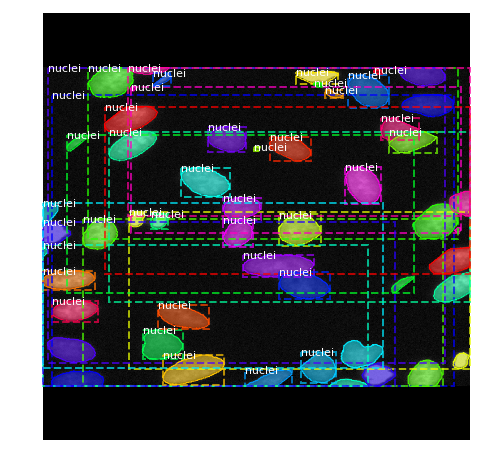

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  225.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  121.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


In [66]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
image_id = 132
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

##Export Results for Submission


In [51]:
# Load test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(TEST_PATH, test_ids)
dataset_test.prepare()
print(len(dataset_test.image_ids))

65


In [52]:
# Test RLE encoding functions on train set masks
# mask_test, _ = dataset_train.load_mask(0)

# print(mask_test.shape)
# print(pd.Series(mask_encode(mask_test)).apply(lambda x: ' '.join(str(y) for y in x)))


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


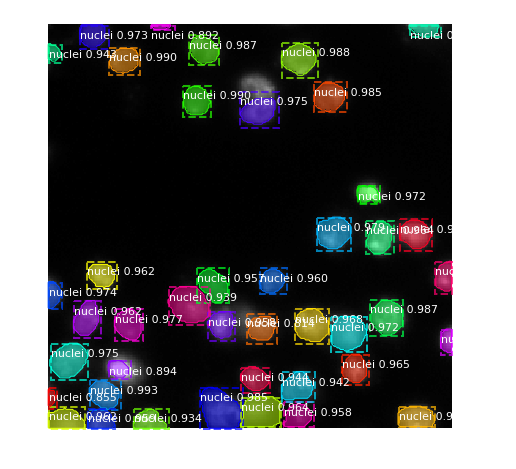

(256, 256, 42)


In [53]:
# Pick a test image to visualize
image = dataset_test.load_image(25)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

print(r['masks'].shape)

In [54]:
# Run detection on all test and do RLE encoding

new_test_ids = []
rles = []
for image_id in dataset_test.image_ids:
    print('Processing: ' + test_ids[image_id])
    try:    
        image = dataset_test.load_image(image_id)
        results = model.detect([image], verbose=0)
        r = results[0]

        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax(), title=test_ids[image_id])
    
        rle = mask_encode(remove_overlap(r['masks']))
        rles = np.append(rles, rle)
        new_test_ids.extend([test_ids[image_id]] * len(rle))
    except:
        continue
print(len(rles))
print(len(new_test_ids))

Processing: 0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


Processing: 0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


Processing: 0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


Processing: 0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925


Processing: 0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6


Overlapping mask detected!
Processing: 0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466


Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!

Processing: 1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c


Processing: 17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b


Processing: 191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829


Processing: 1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e


Overlapping mask detected!
Processing: 1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1


Overlapping mask detected!


Processing: 1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c


Processing: 259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!


Processing: 295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549


Processing: 31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a


Processing: 336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523


Overlapping mask detected!
Overlapping mask detected!


Processing: 38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f


Processing: 3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26


Processing: 432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580


Overlapping mask detected!


Processing: 43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af


Overlapping mask detected!
Processing: 44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078

Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!


Processing: 4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2


Overlapping mask detected!
Processing: 472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71


Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!


Processing: 4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee


Processing: 4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac


Overlapping mask detected!
Processing: 505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81


Processing: 519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0


Processing: 51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b


Processing: 52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde


Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!


Processing: 53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4


Processing: 550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18


Overlapping mask detected!


Processing: 5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7


Overlapping mask detected!
Processing: 648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9


Processing: 697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808


Overlapping mask detected!
Overlapping mask detected!
Processing: 699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68


Overlapping mask detected!


Overlapping mask detected!


Processing: 78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d


Overlapping mask detected!


Overlapping mask detected!


Processing: 7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04


Processing: 7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af


Processing: 8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b


Processing: 8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab


Overlapping mask detected!


Processing: 912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2


Processing: 9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab


Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Processing: a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f


Processing: a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8


Processing: ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e


Overlapping mask detected!
Overlapping mask detected!


Processing: b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3


Overlapping mask detected!


Processing: bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d


Overlapping mask detected!
Overlapping mask detected!


Processing: c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb


Processing: ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef


Processing: d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d


Overlapping mask detected!
Overlapping mask detected!
Processing: d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896


Overlapping mask detected!


Processing: d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b


Processing: da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab


Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!


Processing: dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4


Processing: df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8


Processing: e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258


Processing: eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835


Processing: f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4


Overlapping mask detected!


Processing: f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3


Overlapping mask detected!
Overlapping mask detected!
Processing: fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f


Overlapping mask detected!
2751
2751


In [58]:
# Save results for submission

import pandas as pd

# Create submission DataFramevim
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submit/sub-dsbowl2018-8.csv', index=False)